# Testing the ability to distinguish signal events from background

In [7]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [8]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

### Record (Raw) Wire Features 

In [9]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Signal like or not (apriori)
sig_like = numpy.vstack(hits.get_prob_sig_wire(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [10]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Preapre Neighbour Features

In [11]:
# Sum of energy desposits of neighbours 
sum_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T).T
# Sum of neighbouring neighbour deposits (smoothed clustering)
sum_neigh_deposits_2 = hits.cydet.point_neighbours.dot(sum_neigh_deposits.T).T
sum_neigh_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# Number of neighbours with hits
num_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T > 0).T
# Number of signal-like neighbours
sig_like_neighs = hits.cydet.point_neighbours.dot(sig_like.T).T

### Left/Right Neighbour Features

In [12]:
# Sum of energy desposits of left/right neighbours 
sum_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T).T
# Sum of left/right neighbouring left/right neighbour deposits
sum_lr_deposits_2 = hits.cydet.lr_neighbours.dot(sum_neigh_deposits.T).T
sum_lr_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# Number of neighbours with hits
num_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T > 0).T
# Number of signal-like neighbours
sig_like_lr = hits.cydet.lr_neighbours.dot(sig_like.T).T
# Sum of relative timing of left/right neighbours
sum_lr_time = hits.cydet.lr_neighbours.dot(rel_time.T).T
# Get difference measure of time between hit and possible neighbouring hits
# diff_lr_time_metric = numpy.vstack(hits.get_time_neighbours_metric(i) for i in range(hits.n_events))

In [13]:
# diff_lr_time_metric = numpy.log(diff_lr_time_metric)

NameError: name 'diff_lr_time_metric' is not defined

## Train/test splitting 

In [14]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(len(labels)), train_size=0.15, test_size=0.25)

In [15]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id
# Neighbour Features
features['sum_neigh_deposits'] = sum_neigh_deposits * 100
features['num_neigh_deposits'] = num_neigh_deposits
features['sum_neigh_deposits_2'] = sum_neigh_deposits_2
features['sig_like_neighs'] = sig_like_neighs
# Left-Right neighbour features
features['sum_lr_deposits'] = sum_lr_deposits * 100
features['sum_lr_time'] = sum_lr_time
features['num_lr_deposits'] = num_lr_deposits
features['sum_lr_deposits_2'] = sum_lr_deposits_2
features['sig_like_lr'] = sig_like_lr
# features['diff_lr_time_metric'] = diff_lr_time_metric
# Truth values
features['labels'] = labels

In [16]:
train_features = features.keys()[:-1]

In [17]:
data = numpy.dstack(features.values())

In [18]:
data.shape

(3445, 4482, 13)

In [19]:
n_feats = data.shape[-1]
train_data, test_data = data[train_events].reshape(-1, n_feats), data[test_events].reshape(-1, n_feats)

In [20]:
import pandas
train_data = pandas.DataFrame(data=train_data, columns=features.keys())
test_data = pandas.DataFrame(data=test_data, columns=features.keys())
test_data_orig = test_data

/usr/lib64/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


### Purge out cells with no hits, relabel 1 as signal hit, 0 as background hit

In [21]:
train_data = train_data[train_data['labels'] != 0]
test_data = test_data[test_data['labels'] != 0]

train_data['labels'] = 2 - train_data['labels']
test_data['labels'] = 2 - test_data['labels']

/home/elg112/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Using simple GBRT to determine if wire is signal

In [22]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
factory = ClassifiersFactory()
gb_all_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
gb_deposit = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=['deposit'])
factory.add_classifier('All Features', gb_all_features)
factory.add_classifier('Energy Deposit', gb_deposit)

In [24]:
factory.fit(train_data, train_data['labels'])
pass

model All Features was trained in 86.03 seconds
model Energy Deposit was trained in 15.02 seconds
Totally spent 101.04 seconds on training


In [25]:
predictions = factory.test_on(test_data, test_data['labels'])

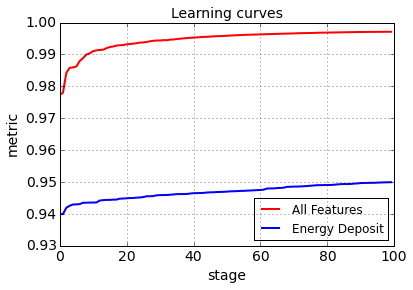

In [26]:
from rep.report.metrics import RocAuc
predictions.learning_curve(RocAuc(), steps=1)

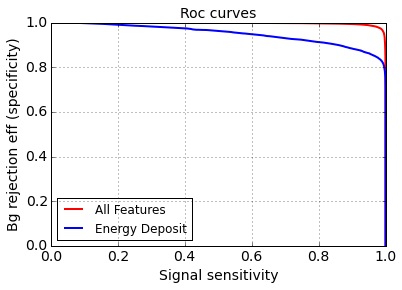

In [27]:
roc = predictions.roc()
roc.plot()

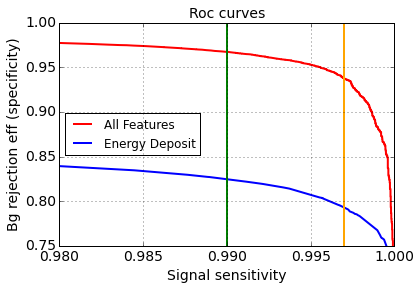

In [28]:
roc.plot(xlim=[0.98,1.], ylim=[0.75,1.])
plt.plot([.99, .99], [0.75, 1.], 'k-', lw=2,  c='g' )
plt.plot([.997, .997], [0.75, 1.], 'k-', lw=2,c='orange')


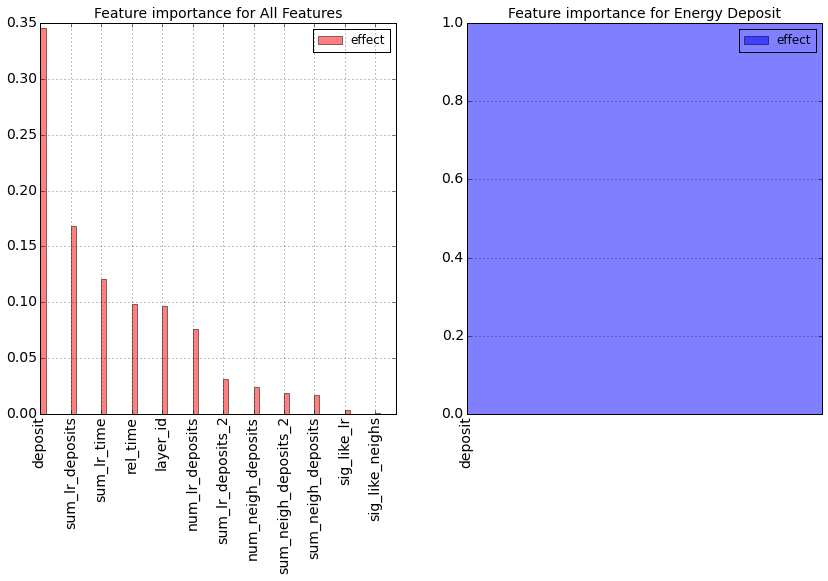

In [29]:
predictions.feature_importance().plot(figsize=[14, 7])

In [30]:
corr = predictions.features_correlation_matrix(features=train_features)
corr.cmap = "PuOr"

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


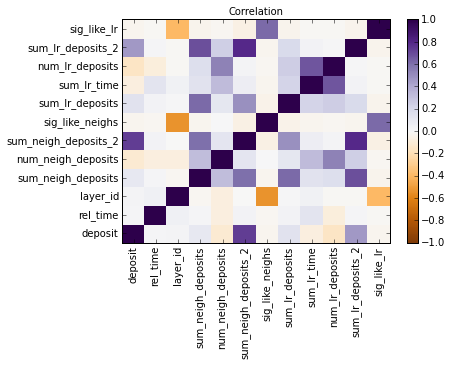

In [31]:
corr.plot()

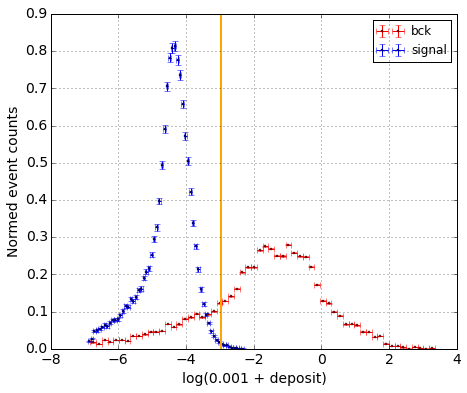

In [32]:
dep = predictions.features_pdf(features=['log(0.001 + deposit)'], bins=60)
dep.plot()
plt.plot([log(0.001+0.05), log(0.001+0.05)], [0, 0.9], 'k-', lw=2,c='orange')

### Measure Effectiveness of GBDT

In [33]:
#n_bins = 10
#bin_width = 1./n_bins
#p = predictions.prediction['All Features'][:, 1]
#fpr, tpr, thresholds = roc_curve(test_data['labels'], p)
#signal_weight = 

#limits = numpy.percentile(p, [10, 20, 30, 40, 50, 60, 70, 80, 90])
#bin_indices = numpy.searchsorted(limits, p)
#s = numpy.bincount(bin_indices, weight=signal_weight)
#b = numpy.bincount(bin_indices, weight=bck_weight)
#result = numpy.sum(s * s / (b + regularization))

### Applying the Hough Transform

In [34]:
from tracking import Hough
from sklearn.preprocessing import normalize
hough = Hough(hits)

In [58]:
# Set the test data that has all wires to the hough training data, with original labels
hough_data = test_data_orig

# Take only the all features GBDT from here on out
gbdt = factory['All Features']

# Apply to the hough training data
gbdt_out = gbdt.predict_proba(hough_data)

# Take only the signal probability
gbdt_out = gbdt_out[:,1]

# Define which wires were unhit
hough_unhit = np.where(hough_data['labels'] == 0)[0]

# Set all wires with no hits to zero
gbdt_out[hough_unhit] = 0

In [65]:
# Reground wires by event, i.e. reshape so that each event has cydent.n_points
gbdt_out = gbdt_out.reshape(-1,hits.cydet.n_points)

# Split data into even and odd layers

# Acquire the forward and reverse hough transforms
hough_forward = hough.correspondence.T
hough_forward = normalize(hough_forward, norm='l2', axis=1)
hough_inverse = hough.correspondence

# Apply the forward hough transforms to all events 
# This defines the probability of a track center
hough_out = numpy.vstack(hough_forward.dot(gbdt_out[i,:]) for i in range(gbdt_out.shape[0]))

# Apply the inverse hough transform to the exponentiated hough transform out put
# This weights track points closer to the tracks as more likely
inv_hough_out = numpy.vstack(hough_inverse.dot( numpy.exp(hough_out[i,:]) ) for i in range(gbdt_out.shape[0]))

<type 'numpy.ndarray'>
(862, 4482)
(862, 2808)
(862, 4482)


In [66]:
# Flatten our new features to match the old ones
gbdt_out_feat = gbdt_out.reshape(-1)
int_hough_out_feat = gbdt_out.reshape(-1)

# Define new feature list, adding to the old one
hough_data['gbdt_out'] = gbdt_out_feat
hough_data['inv_hough_out'] = int_hough_out_feat

# Remove all unhit wires from the data
hough_hit = np.where(hough_data['labels'] != 0)[0]
gbdt_out_feat = gbdt_out_feat[hough_hit]
int_hough_out_feat = int_hough_out_feat[hough_hit]

# Relabel signal as 1, background as 0
hough_data['labels'] = 2 - hough_data['labels']

In [ ]:
# Extract signal that was missed by GBDT
hough_test_data = hough_data["labels" == 1,"gbdt_out" < 0.9]
# Extract background that was included by GBDT
hough_test_data += hough_data["labels" == 0,"gbdt_out" > 0.1]

In [36]:
predictions = numpy.concatenate()
labels = numpy.concatenate
roc_curve(labels, predictions)

NameError: name 'hit_vector' is not defined

### Original Background Regection/Singal Retention at 5 KeV

In [ ]:
n_sig = 0 
n_sig_pass = 0
n_bkg = 0 
n_bkg_pass = 0
for evt in range(hits.n_events):
        sig_wires = hits.get_sig_wires(evt)
        sig_wires_pass = where(hits.get_energy_deposits(evt)[sig_wires] < 0.000005)[0]
        n_sig += len(sig_wires)
        n_sig_pass += len(sig_wires_pass)
        
        bkg_wires = hits.get_bkg_wires(evt)
        bkg_wires_pass = where(hits.get_energy_deposits(evt)[bkg_wires] < 0.000005)[0]
        n_bkg += len(bkg_wires)
        n_bkg_pass += len(bkg_wires_pass)
print "Signal Retention Rate {}".format(n_sig_pass/float(n_sig))
print "Background Rejection Rate {}".format(n_bkg_pass/float(n_bkg))

# Save these values for comparison later
tpr_orig = n_sig_pass/float(n_sig)
fpr_orig = n_bkg_pass/float(n_bkg)

In [ ]:
# from sklearn.metrics import roc_curve
new_tpr = 0.99
new_fpr = 0.10
p = predictions.prediction['All Features'][:, 1]
fpr, tpr, thresholds = roc_curve(test_data['labels'], p)
tpr_orig_index =  where(tpr > tpr_orig)[0][1]
fpr_orig_index =  where(fpr > fpr_orig)[0][1]

tpr_new_index =  where(tpr > new_tpr)[0][1]
fpr_new_index =  where(fpr > new_fpr)[0][1]

print "At signal retetion rate at 5 KeV cut, {0:.5f} , background regjection has changed from".format(tpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_orig_index],fpr_orig-fpr[tpr_orig_index]) + \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_orig_index]))
print "At background retetion rate at 5 KeV cut, {0:.5f} , signal retention has changed from".format(1-fpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_orig_index], tpr[fpr_orig_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_orig_index]))

print "At new signal retention of {0:.5f}, background regjection has changed from".format(new_tpr) + \
      "\n{0:.5f} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_new_index], fpr_orig-fpr[tpr_new_index])+ \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_new_index]))
print "At new background rejection rate of {0:.5f}, signal retention has changed from".format(new_fpr) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_new_index], tpr[fpr_new_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_new_index]))
